In [0]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week5()
import keras
from keras import backend as K
import download_utils
#import keras_utils
import tqdm_utils
import keras_utils
from keras_utils import reset_tf_session

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:
pad_token = "#"

with open('/content/gdrive/My Drive/ names_rnn.txt') as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [0]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


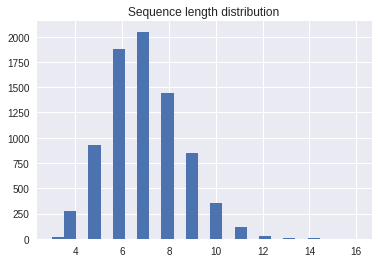

In [0]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

In [0]:
print(names[:5])
tokens = set(''.join(names[:]))
print(tokens)
tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

[' Abagael', ' Abagail', ' Abbe', ' Abbey', ' Abbi']
{'y', 'q', 'a', 'r', 'K', 'l', 'G', 'v', 'c', 'n', 'X', 'V', 'L', 'P', 'C', 'u', "'", 'z', 'I', 'O', 't', 'f', 'A', 'H', 'B', 'W', 'R', 'g', 'e', ' ', 'E', 'Q', '-', 'D', 'Z', 'k', 'M', 's', 'S', 'm', 'J', 'T', 'Y', 'w', 'N', 'o', 'p', 'd', 'i', 'F', 'b', 'U', 'j', 'h', 'x'}
n_tokens: 55


In [0]:
#token_to_id = ### YOUR CODE HERE: create a dictionary of {symbol -> its  index in tokens}
token_to_id = {}
for i in range(n_tokens):
    token_to_id[tokens[i]] = i
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

In [0]:
def to_matrix(names, max_len=None, pad=0, dtype=np.int32):
    """Casts a list of names into rnn-digestable padded matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [0]:
# Example: cast 4 random names to padded matrices (so that we can easily batch them)
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[29 22 50  2 27  2 28  5  0]
 [29  6  5 45  3  0  0  0  0]
 [29 13  3 48 37 37 48 28  0]
 [29  6 48 45  7  2  9  9 28]]


In [0]:
# remember to reset your session if you change your graph!
s = keras_utils.reset_tf_session()
#s = reset_tf_session()

In [0]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64  # size of hidden state
embedding_size = 16  # for characters

# Let's create layers for our recurrent network
# Note: we create layers but we don't "apply" them yet (this is a "functional API" of Keras)
# Note: set the correct activation (from keras.activations) to Dense layers!

# an embedding layer that converts character ids into embeddings
embed_x = Embedding(n_tokens, embedding_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t]->h_t+1
#get_h_next = ### YOUR CODE HERE
get_h_next = Dense(rnn_num_units, activation = "relu")
# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
#get_probas = ### YOUR CODE HERE 
get_probas = Dense(n_tokens, activation="softmax")

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces 
    probabilities for next token x_t+1 and next state h_t+1
    given current input x_t and previous state h_t.
    We'll call this method repeatedly to produce the whole sequence.
    
    You're supposed to "apply" above layers to produce new tensors.
    Follow inline instructions to complete the function.
    """
    # convert character id into embedding
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    
    # concatenate x_t embedding and previous h_t state
    #x_and_h = ### YOUR CODE HERE
    x_and_h = tf.concat([x_t_emb,h_t],1)
    # compute next state given x_and_h
    #h_next = ### YOUR CODE HERE
    h_next = get_h_next(x_and_h)
    
    # get probabilities for language model P(x_next|h_next)
    #output_probas = ### YOUR CODE HERE
    output_probas = get_probas(h_next)
    
    return output_probas, h_next

In [0]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  # batch of token ids
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units])  # initial hidden state

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    
# combine predicted_probas into [batch, time, n_tokens] tensor
predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])

# next to last token prediction is not needed
predicted_probas = predicted_probas[:, :-1, :]

In [0]:
# flatten predictions to [batch*time, n_tokens]
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

# flatten answers (next tokens) and one-hot encode them
answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [0]:
# Define the loss as categorical cross-entropy (e.g. from keras.losses).
# Mind that predictions are probabilities and NOT logits!
# Remember to apply tf.reduce_mean to get a scalar loss!
#loss = ### YOUR CODE HERE
from keras.objectives import categorical_crossentropy
loss = tf.reduce_mean(categorical_crossentropy(answers_matrix, predictions_matrix))
optimize = tf.train.AdamOptimizer().minimize(loss)

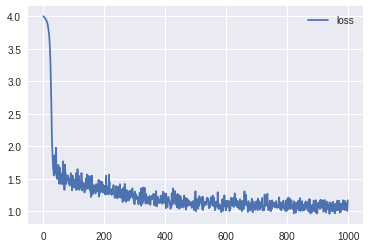

In [0]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge"

In [0]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  # we will update hidden state in this variable


next_probs, next_h = rnn_one_step(x_t, h_t)

In [0]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
    '''
    This function generates text given a `seed_phrase` as a seed.
    Remember to include start_token in seed phrase!
    Parameter `max_length` is used to set the number of characters in prediction.
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))
    
    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})
    
    # start generating
    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [0]:
# without prefix
for _ in range(10):
    print(generate_sample())

 Pubynyyyyyyyyyy
 Gojlenemyyyyyyy
 Frinlyyyyyyyyyy
 Haveoldyyyyyyyy
 Sedyyyyyyyyyyyy
 Voirlteyyyyyyyy
 Conisisyyyyyyyy
 Kusciyyyyyyyyyy
 Sardayyyyyyyyyy
 Aureyyyyyyyyyyy


In [0]:
# with prefix conditioning
for _ in range(10):
    print(generate_sample(' Trump'))

 Trumpayyyyyyyyy
 Trumpaydyyyyyyy
 Trumparyyyyyyyy
 Trumpisyyyyyyyy
 Trumpneloyyyyyy
 Trumpeeyyyyyyyy
 Trumpishayyyyyy
 Trumpieyyyyyyyy
 Trumpoeenyyyyyy
 Trumpityyyyyyyy


In [0]:
input_sequence = tf.placeholder(tf.int32, (None, None))

inputs_embedded = embed_x(input_sequence)

# standard cell returns hidden state as output!
cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence, last_state = tf.nn.dynamic_rnn(cell, inputs_embedded, dtype=tf.float32)

s.run(tf.global_variables_initializer())

print('LSTM hidden state for each step [batch,time,rnn_num_units]:')
print(state_sequence.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape)